In [26]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

In [27]:
data_directory = "../Data/unh_hackathon_prompt_2_data.json"
sys.path.append("../UNH-Hackathon-2026-Group-3/")

## preparing the data


In [28]:
def load_predictive_warfighting_data(file_path: str = "unh_hackathon_prompt_2_data.json") -> pd.DataFrame:
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_json(file_path)

dirty_df = load_predictive_warfighting_data(data_directory)

# print data types of each column
# print(dirty_df.dtypes)

In [29]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean the DataFrame by converting data types."""

    # Convert the string "NULL" to pd.NA
    df = df.replace("NULL", pd.NA)
    df = df.replace("N/A", pd.NA)

    for numeric_string_column in [
        "Enemy.Capability.Index",
        "EW_Capability",
        "Intel Confidence",

    ]:
        df[numeric_string_column] = pd.to_numeric(df[numeric_string_column])

    for boolean_string_column in [
        "response_success"
    ]:
        df[boolean_string_column] = df[boolean_string_column].map({"Yes": 1, "No": 0, "1": 1, "0": 0})

    return df

df = clean_data(dirty_df)

# get unique values for each string column, and min/max for each numeric column
for column in df.columns:
    if df.dtypes[column] == "str":
        print(f"Values: {df[column].drop_duplicates()}")
    else: 
        print(f"Name: {column}, dtype: {df.dtypes[column]}, min: {df[column].min()}, max: {df[column].max()}")

print(f"number of rows: {len(df)}")     
df.head()

Values: 0       Missile
2           Air
3         Cyber
4        Hybrid
7         Naval
14          AIR
35        CYBER
39       Hybrid
43          Msl
79        naval
119       Cyber
239         AIR
279         Air
299       naval
319     Missile
Name: Threat Type, dtype: str
Name: enemy_unit_count, dtype: int64, min: 1, max: 50
Name: Enemy.Capability.Index, dtype: int64, min: 1, max: 10
Name: ThreatEscalationHours, dtype: int64, min: 1, max: 72
Name: friendlyUnitCount, dtype: int64, min: 5, max: 60
Name: LCS_COUNT, dtype: int64, min: 0, max: 8
Name: Aircraft Count, dtype: int64, min: 0, max: 24
Name: cyber_defense_teams, dtype: int64, min: 0, max: 12
Name: Patriot.Batteries, dtype: int64, min: 0, max: 6
Name: ISR_AssetCount, dtype: int64, min: 0, max: 15
Name: satellite coverage score, dtype: float64, min: 0.2, max: 1.0
Name: JointForceIntegration, dtype: int64, min: 1, max: 10
Name: EW_Capability, dtype: float64, min: 0.0, max: 10.0
Name: Supply Chain Resilience, dtype: float64, min

,Threat Type,enemy_unit_count,Enemy.Capability.Index,ThreatEscalationHours,friendlyUnitCount,LCS_COUNT,Aircraft Count,cyber_defense_teams,Patriot.Batteries,ISR_AssetCount,...,CMD_COORD_SCORE,roe_complexity_score,Operational Budget (MUSD),BudgetUtilization_pct,Weather_Severity,Theater Distance KM,Season,response_success,Financial_Loss_MUSD,actual_days_to_stabilization
0,Missile,25,8,34,21,0,0,0,4,12,...,7,3,98,84,3,5164.8,Winter,1,388,10.1
1,Missile,3,2,8,45,0,0,0,4,4,...,9,5,189,97,1,7149.7,Fall,1,244,2.0
2,Air,7,3,48,45,0,5,0,0,14,...,9,1,92,88,0,6706.5,Winter,1,280,2.0
3,Cyber,31,7,70,57,0,0,7,0,5,...,10,3,314,86,9,1851.9,Fall,1,330,5.3
4,Hybrid,14,5,27,57,0,0,0,0,10,...,6,4,290,84,4,983.7,Spring,1,240,11.0


In [30]:
# get count of rows for each threat type 
threat_type_counts = df["Threat Type"].value_counts()
threat_type_counts

Threat Type
Naval       741
Air         684
Hybrid      557
Cyber       425
Missile     408
AIR          42
CYBER        32
Msl          21
 naval       19
 Hybrid      15
naval        15
 Cyber       13
 Missile     13
 Air         10
 AIR          5
Name: count, dtype: int64

In [31]:
# combine "Naval", "  naval", and "naval" into same category 
df["Threat Type"] = df["Threat Type"].str.strip()  # Remove leading/trailing whitespace
df["Threat Type"] = df["Threat Type"].str.lower()  # Convert to lowercase for consistency

# combine missile and msl into same threat type 
df["Threat Type"] = df["Threat Type"].replace({"msl": "missile"})

threat_type_counts = df["Threat Type"].value_counts()
threat_type_counts


Threat Type
naval      775
air        741
hybrid     572
cyber      470
missile    442
Name: count, dtype: int64

In [32]:
# remove rows with nan values in any column 
df = df.dropna()
len(df)

2945

In [33]:
# filter by threat type here 

In [34]:
# get array of values for input variables:
''' 
every column except output/results and categorical variables 
'''
input_columns = df.select_dtypes(include=[np.number]).columns.tolist()
input_columns.remove('response_success')
input_columns.remove('Financial_Loss_MUSD')
input_columns.remove('actual_days_to_stabilization')
inputs = df[input_columns].values


# get array of values for output variables:
'''
response_success, dtype: int64
Financial_Loss_MUSD, dtype: int64
actual_days_to_stabilization, dtype: float64
'''
response_successes = df['response_success'].values
financial_loss_musds = df['Financial_Loss_MUSD'].values
actual_days_to_stabilizations = df['actual_days_to_stabilization'].values

output = financial_loss_musds

len(inputs[0]), inputs[0:3], output[0:3]

(24,
 array([[2.5000e+01, 8.0000e+00, 3.4000e+01, 2.1000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.0000e+00, 1.2000e+01, 5.9000e-01,
         3.0000e+00, 2.0000e+00, 4.9000e-01, 1.8000e+01, 6.9000e+01,
         8.2000e-01, 2.9000e+01, 2.4000e+01, 7.0000e+00, 3.0000e+00,
         9.8000e+01, 8.4000e+01, 3.0000e+00, 5.1648e+03],
        [3.0000e+00, 2.0000e+00, 8.0000e+00, 4.5000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00, 5.5000e-01,
         9.0000e+00, 6.0000e+00, 9.4000e-01, 1.3000e+01, 6.2000e+01,
         8.5000e-01, 4.7000e+01, 7.0000e+00, 9.0000e+00, 5.0000e+00,
         1.8900e+02, 9.7000e+01, 1.0000e+00, 7.1497e+03],
        [7.0000e+00, 3.0000e+00, 4.8000e+01, 4.5000e+01, 0.0000e+00,
         5.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e+01, 8.8000e-01,
         3.0000e+00, 1.0000e+00, 6.3000e-01, 2.0000e+00, 1.0000e+02,
         8.1000e-01, 3.6000e+01, 3.0000e+00, 9.0000e+00, 1.0000e+00,
         9.2000e+01, 8.8000e+01, 0.0000e+00, 6.7065

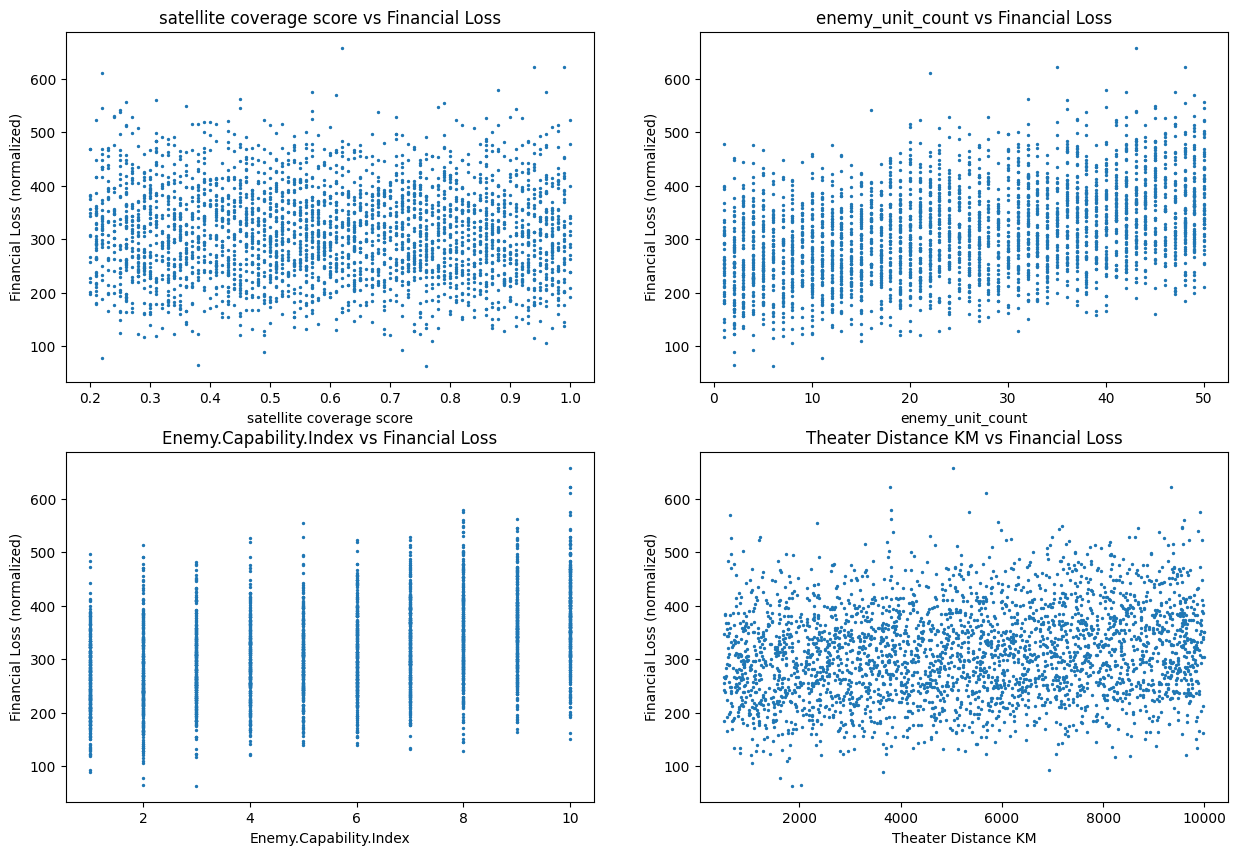

In [35]:
# plot input vs output for some input variables
input_names = [
    'satellite coverage score',
    'enemy_unit_count',
    'Enemy.Capability.Index',
    'Theater Distance KM'
]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(df[input_names[i]], output, s=2)
    ax.set_xlabel(input_names[i])
    ax.set_ylabel("Financial Loss (normalized)")
    ax.set_title(f"{input_names[i]} vs Financial Loss")


## preparing + running the model to predict financial loss

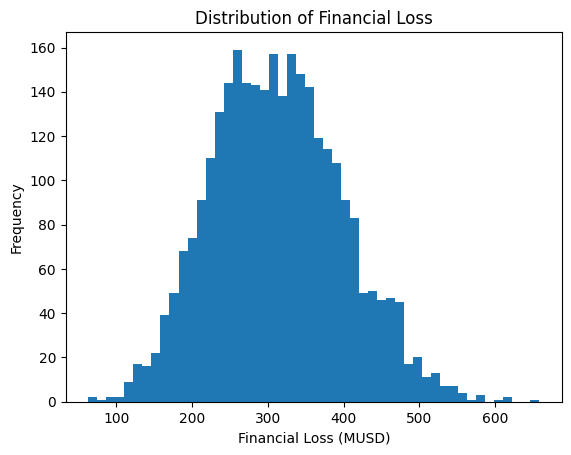

In [36]:
# visualize the distribution 
plt.hist(financial_loss_musds, bins=50)
plt.xlabel("Financial Loss (MUSD)")
plt.ylabel("Frequency")
plt.title("Distribution of Financial Loss")
plt.show()

In [37]:
class NNmodel(nn.Module):
    def __init__ (self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(inputs), 30),
            nn.ReLU(),
            nn.Linear(30, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [38]:
print(torch.tensor(inputs).float()[0])
print(torch.tensor(inputs).float().size())

tensor([2.5000e+01, 8.0000e+00, 3.4000e+01, 2.1000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.0000e+00, 1.2000e+01, 5.9000e-01, 3.0000e+00, 2.0000e+00,
        4.9000e-01, 1.8000e+01, 6.9000e+01, 8.2000e-01, 2.9000e+01, 2.4000e+01,
        7.0000e+00, 3.0000e+00, 9.8000e+01, 8.4000e+01, 3.0000e+00, 5.1648e+03])
torch.Size([2945, 24])


In [44]:
input_tensor = torch.tensor(inputs).float() 
input_tensor[0]

tensor([2.5000e+01, 8.0000e+00, 3.4000e+01, 2.1000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.0000e+00, 1.2000e+01, 5.9000e-01, 3.0000e+00, 2.0000e+00,
        4.9000e-01, 1.8000e+01, 6.9000e+01, 8.2000e-01, 2.9000e+01, 2.4000e+01,
        7.0000e+00, 3.0000e+00, 9.8000e+01, 8.4000e+01, 3.0000e+00, 5.1648e+03])

In [39]:
class AbsDataset(Dataset):
    def __init__ (self, inputs, output):
        self.input_tensor = torch.tensor(inputs).float() 
        self.output_tensor = torch.tensor(output).float()
        
    def __len__(self):
        return len(self.output_tensor)
    
    def __getitem__(self, idx):
        return self.input_tensor[idx], self.output_tensor[idx] 
    

In [40]:
# train/test split 

full_dataset = AbsDataset(inputs, output)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(len(train_dataset), len(train_dataset.dataset))

2356 2945


In [54]:
train_dataset.dataset[train_dataset.indices][0] == full_dataset[train_dataset.indices][0]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [42]:
# normalize datasets based on train dataset statistics
# for each column in train dataset, get mean and std
# then normalize that column in both train and test datasets 

# loader = DataLoader(train_dataset, batch_size=len(train_dataset))
# train_data_array = next(iter(loader))[0]
# train_means = train_data_array.mean(axis=0)
# train_stds = train_data_array.std(axis=0)
temp_data = train_dataset.dataset[train_dataset.indices]
train_means = torch.mean(temp_data, dim=0)
train_stds = torch.std(temp_data, dim=0)

train_dataset.dataset.data[train_dataset.indices] = (train_dataset.dataset.data[train_dataset.indices] - train_means) / (train_stds + 1e-8) # add small value to avoid division by zero
test_dataset.dataset.data[test_dataset.indices] = (test_dataset.dataset.data[test_dataset.indices] - train_means) / (train_stds + 1e-8)

for i in range(len(train_dataset)): 
    input_tensor, output_tensor = train_dataset[i]
    normalized_input = (input_tensor.numpy() - train_means.numpy()) / train_stds.numpy() # np does element-wise operations
    train_dataset[i] = (torch.tensor(normalized_input).float(), output_tensor)

for i in range(len(test_dataset)):
    input_tensor, output_tensor = test_dataset[i]
    normalized_input = (input_tensor.numpy() - train_means.numpy()) / train_stds.numpy() # np does element-wise operations
    test_dataset[i] = (torch.tensor(normalized_input).float(), output_tensor)

train_means, train_stds

TypeError: mean() received an invalid combination of arguments - got (tuple, dim=int), but expected one of:
 * (Tensor input, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)


In [ ]:
# shuffles and batches 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# initiate model
model = NNmodel()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # learning rate


In [ ]:
# training with per-epoch testing
model.train() 

training_loss_ls = []
test_loss_ls = []

epochs = 20

for epoch in range(epochs):
    epoch_loss_ls = []
    print("epoch #:", epoch)

    # training loop 
    for data, labels in tqdm(train_loader):
        optimizer.zero_grad() # resets gradients in optimizer to 0 
        outputs = model(data)

        # calculate loss function (MSE)
        loss = loss_func(outputs, labels)
        epoch_loss_ls.append(loss.item())
        loss.backward() # back prop 

        # optimizer 
        optimizer.step() # updates all parameters via gradient descent 
        
    avg_loss = np.average(np.array(epoch_loss_ls))
    print("average training loss:", avg_loss)
    training_loss_ls.append(avg_loss)
    
    # testing loop per epoch
    test_epoch_ls = []
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            loss = loss_func(outputs, labels)
            test_epoch_ls.append(loss.item())
    
    avg_test_loss = np.average(np.array(test_epoch_ls))
    print("average test loss:", avg_test_loss)
    test_loss_ls.append(avg_test_loss)

epoch #: 0


  0%|          | 0/74 [00:00<?, ?it/s]/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 74/74 [00:00<00:00, 1386.11it/s]
/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a ta

average training loss: 0.040551330667693876
average test loss: 0.03428122952902409
epoch #: 1


100%|██████████| 74/74 [00:00<00:00, 2538.84it/s]


average training loss: 0.026081668238180714
average test loss: 0.02579086769707786
epoch #: 2


100%|██████████| 74/74 [00:00<00:00, 2137.37it/s]


average training loss: 0.021716875187750603
average test loss: 0.02310775412063342
epoch #: 3


100%|██████████| 74/74 [00:00<00:00, 2497.47it/s]


average training loss: 0.020820534939097392
average test loss: 0.02268601456015188
epoch #: 4


100%|██████████| 74/74 [00:00<00:00, 2413.67it/s]


average training loss: 0.020714681520051247
average test loss: 0.022648897611200747
epoch #: 5


100%|██████████| 74/74 [00:00<00:00, 2532.50it/s]


average training loss: 0.020773553226545855
average test loss: 0.02261918082315082
epoch #: 6


100%|██████████| 74/74 [00:00<00:00, 2513.17it/s]


average training loss: 0.02076308090692839
average test loss: 0.022583583987262172
epoch #: 7


100%|██████████| 74/74 [00:00<00:00, 2519.76it/s]


average training loss: 0.02079409998967438
average test loss: 0.022562325888960566
epoch #: 8


100%|██████████| 74/74 [00:00<00:00, 2536.83it/s]


average training loss: 0.020766687038279063
average test loss: 0.022554775014637235
epoch #: 9


100%|██████████| 74/74 [00:00<00:00, 2521.91it/s]


average training loss: 0.020687999052775873
average test loss: 0.022526184088404982
epoch #: 10


100%|██████████| 74/74 [00:00<00:00, 1164.80it/s]

average training loss: 0.020705909329793742


average test loss: 0.022581432127340047
epoch #: 11


100%|██████████| 74/74 [00:00<00:00, 2395.89it/s]

average training loss: 0.020713814723028523


average test loss: 0.02248922427846117
epoch #: 12


100%|██████████| 74/74 [00:00<00:00, 2297.06it/s]


average training loss: 0.020735459226007398
average test loss: 0.022518924472521986
epoch #: 13


100%|██████████| 74/74 [00:00<00:00, 2319.89it/s]

average training loss: 0.020699556979879335


average test loss: 0.022431728395009596
epoch #: 14


100%|██████████| 74/74 [00:00<00:00, 2243.96it/s]

average training loss: 0.020763396952502632


average test loss: 0.022423657700212984
epoch #: 15


100%|██████████| 74/74 [00:00<00:00, 2252.94it/s]


average training loss: 0.02075291023514158
average test loss: 0.022417710956061446
epoch #: 16


100%|██████████| 74/74 [00:00<00:00, 2425.34it/s]


average training loss: 0.020745818251492205
average test loss: 0.022408402346852516
epoch #: 17


100%|██████████| 74/74 [00:00<00:00, 2299.92it/s]

average training loss: 0.020675535313785076


average test loss: 0.022418859944824152
epoch #: 18


100%|██████████| 74/74 [00:00<00:00, 2199.67it/s]

average training loss: 0.020707236250510085


average test loss: 0.022439305885368088
epoch #: 19


100%|██████████| 74/74 [00:00<00:00, 2205.72it/s]

average training loss: 0.020722112693899387


average test loss: 0.02240686770180523


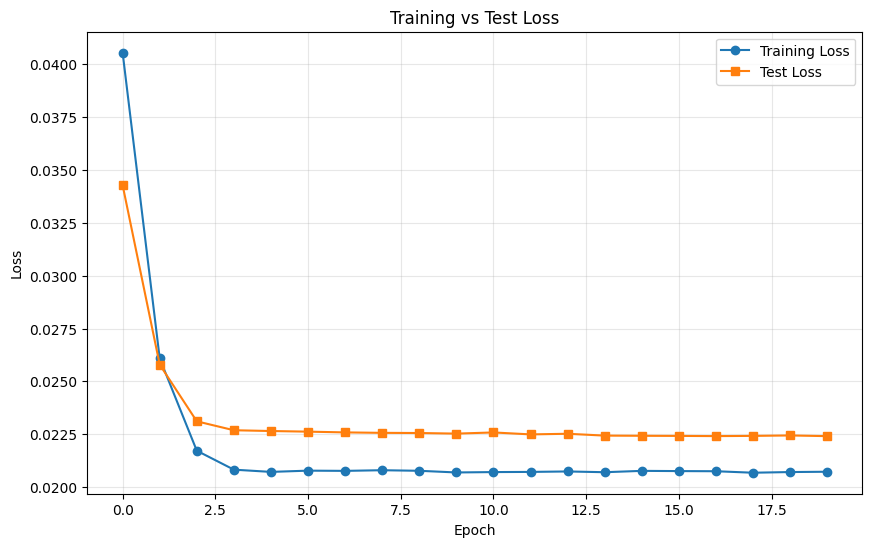

In [15]:
# Plot training and test loss together
x = range(epochs)
plt.figure(figsize=(10, 6))
plt.plot(x, training_loss_ls, label='Training Loss', marker='o')
plt.plot(x, test_loss_ls, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.grid(True, alpha=0.3)
plt.show()

## visualizing model outputs 

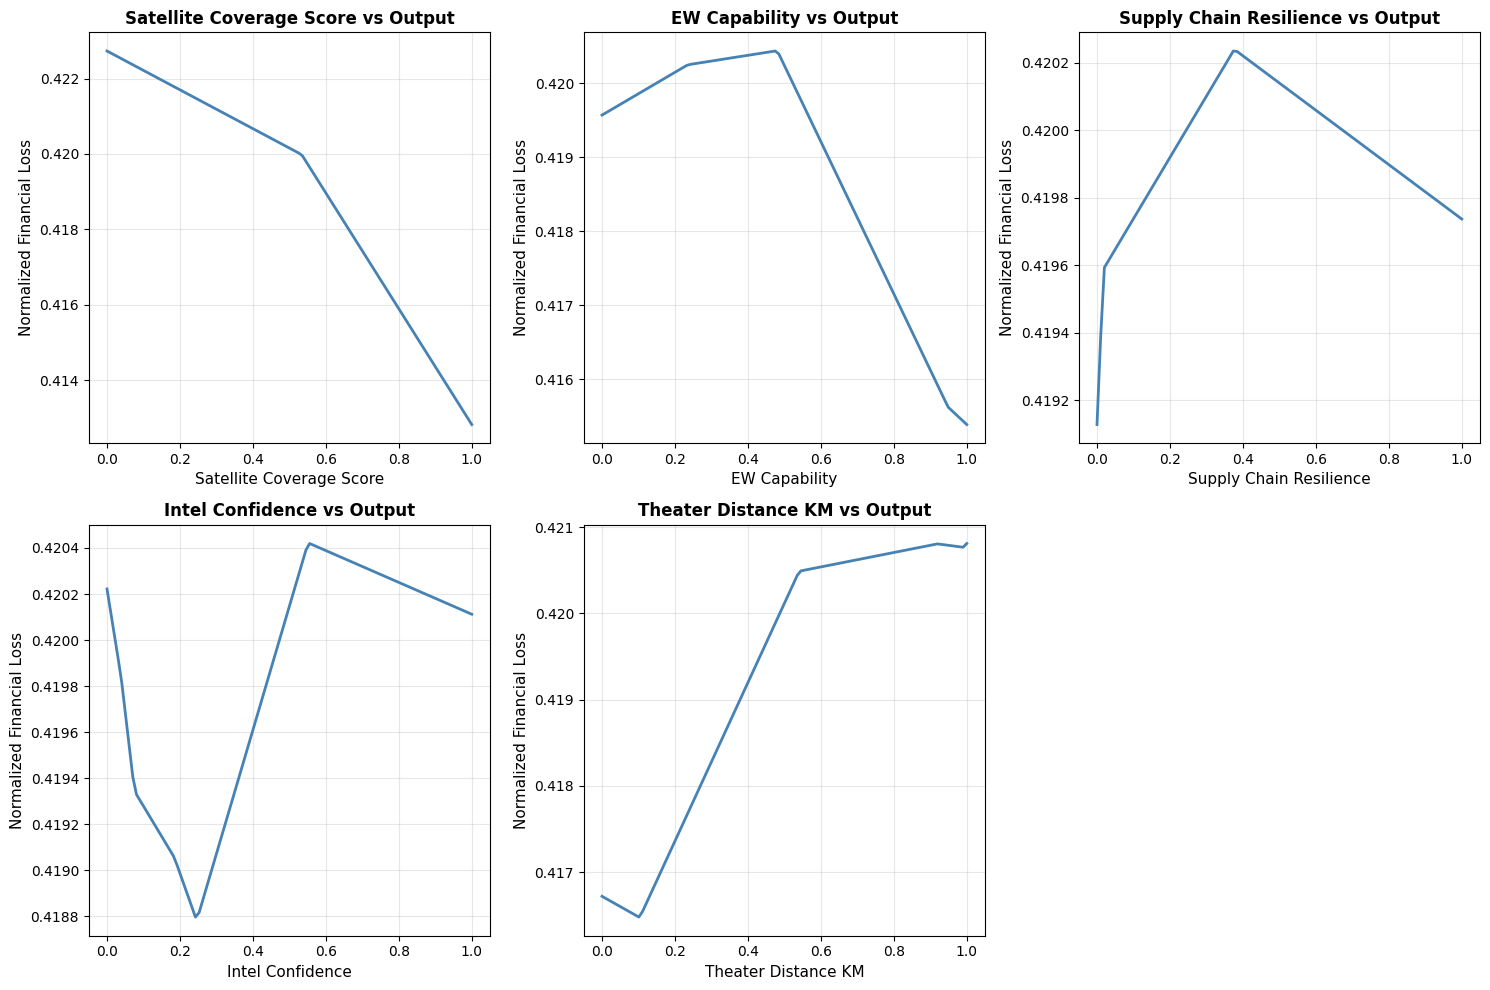

In [ ]:
# ai generated code: 
# Visualize surrogate model: 2D plots of each input vs output
# Create a 2x3 grid with one blank space for the 5 inputs
model.eval() # Set model to evaluation mode

input_names = [
    'Satellite Coverage Score',
    'EW Capability',
    'Supply Chain Resilience',
    'Intel Confidence',
    'Theater Distance KM'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# For each input variable, create predictions while varying that input
for i, ax in enumerate(axes):
    if i < 5:  # Only plot 5 subplots (leave last one blank)
        # Create a range of values for the input variable
        input_range = np.linspace(0, 1, 100)
        
        # Create prediction arrays by holding other inputs at their mean
        predictions = []
        
        for val in input_range:
            # Start with mean normalized values for all inputs
            input_vector = np.mean(inputs, axis=1)
            
            # Vary the current input
            input_vector[i] = val
            
            # Convert to tensor and predict
            input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
            with torch.no_grad():
                pred = model(input_tensor).item()
            predictions.append(pred)
        
        # Plot
        ax.plot(input_range, predictions, linewidth=2, color='steelblue')
        ax.set_xlabel(input_names[i], fontsize=11)
        ax.set_ylabel('Normalized Financial Loss', fontsize=11)
        ax.set_title(f'{input_names[i]} vs Output', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    else:
        # Leave the last subplot blank
        ax.axis('off')

plt.tight_layout()
plt.show()

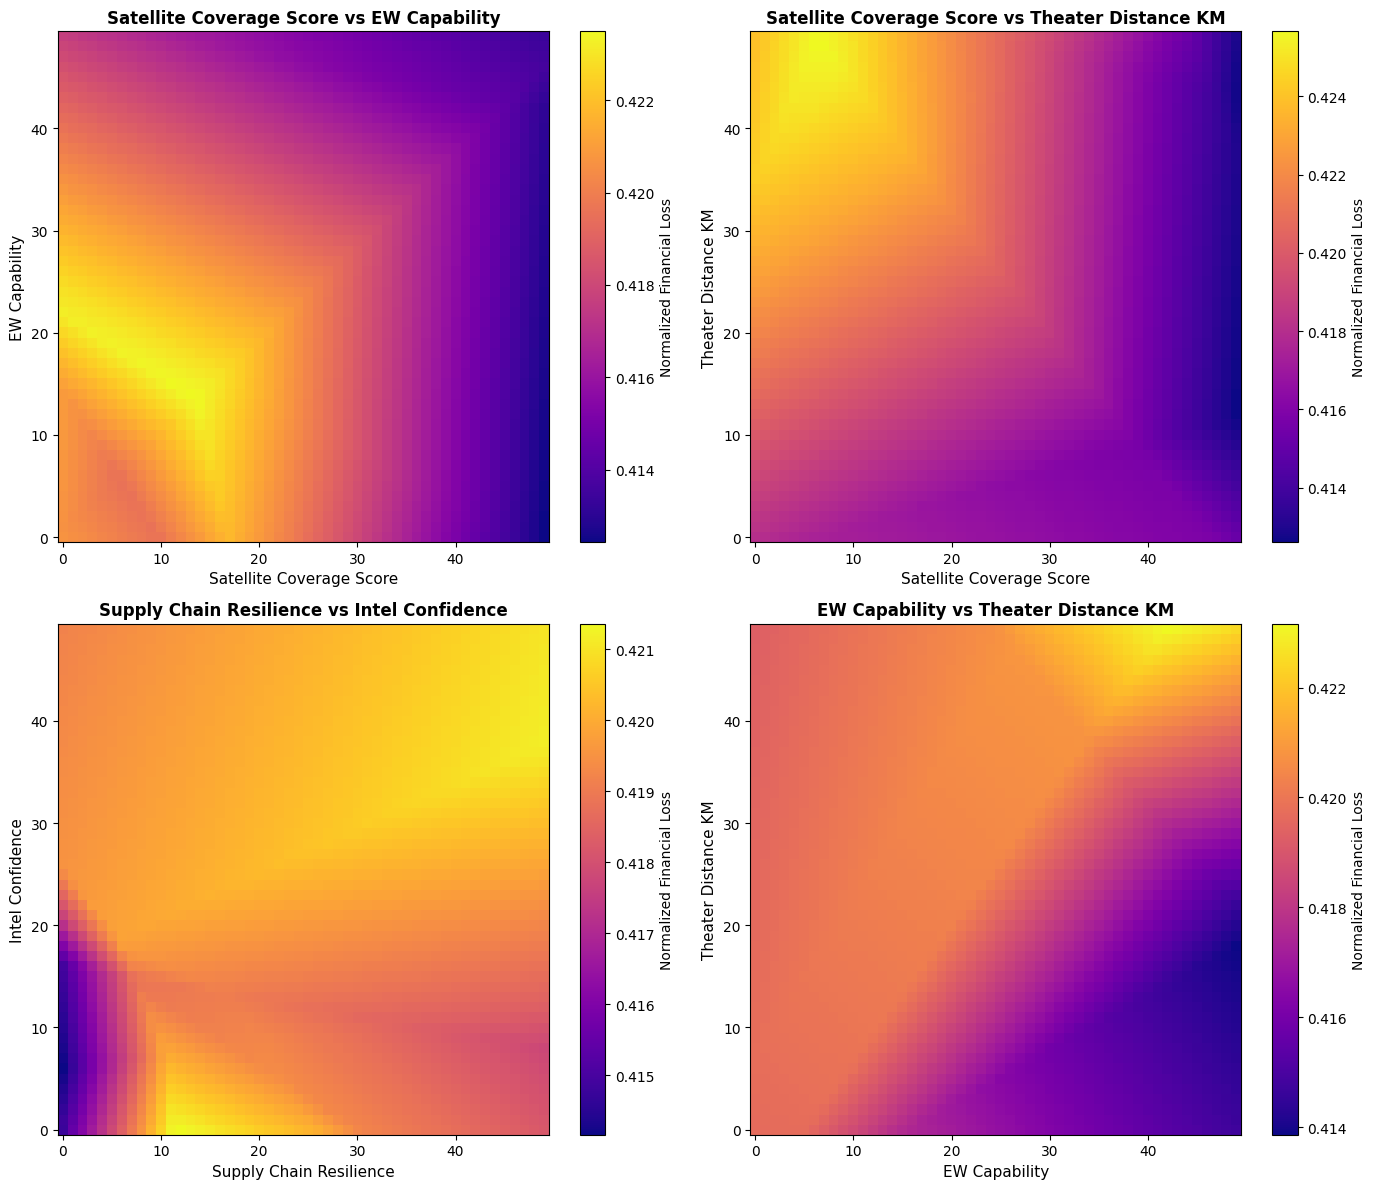

In [17]:
# Create 2D heatmaps for key input pairs
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

input_names = [
    'Satellite Coverage Score',
    'EW Capability',
    'Supply Chain Resilience',
    'Intel Confidence',
    'Theater Distance KM'
]

# Define pairs to visualize (most important interactions)
pairs = [(0, 1), (0, 4), (2, 3), (1, 4)]

for plot_idx, (i, j) in enumerate(pairs):
    ax = axes[plot_idx]
    
    # Create grid of values
    input_range = np.linspace(0, 1, 50)
    heatmap = np.zeros((len(input_range), len(input_range)))
    
    # Fill heatmap by varying inputs i and j
    for x_idx, x_val in enumerate(input_range):
        for y_idx, y_val in enumerate(input_range):
            input_vector = np.mean(inputs, axis=1)
            input_vector[i] = x_val
            input_vector[j] = y_val
            
            input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
            with torch.no_grad():
                pred = model(input_tensor).item()
            heatmap[y_idx, x_idx] = pred
    
    # Plot heatmap with color scale
    im = ax.imshow(heatmap, aspect='auto', origin='lower', cmap='plasma')
    ax.set_xlabel(input_names[i], fontsize=11)
    ax.set_ylabel(input_names[j], fontsize=11)
    ax.set_title(f'{input_names[i]} vs {input_names[j]}', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Normalized Financial Loss')

plt.tight_layout()
plt.show()

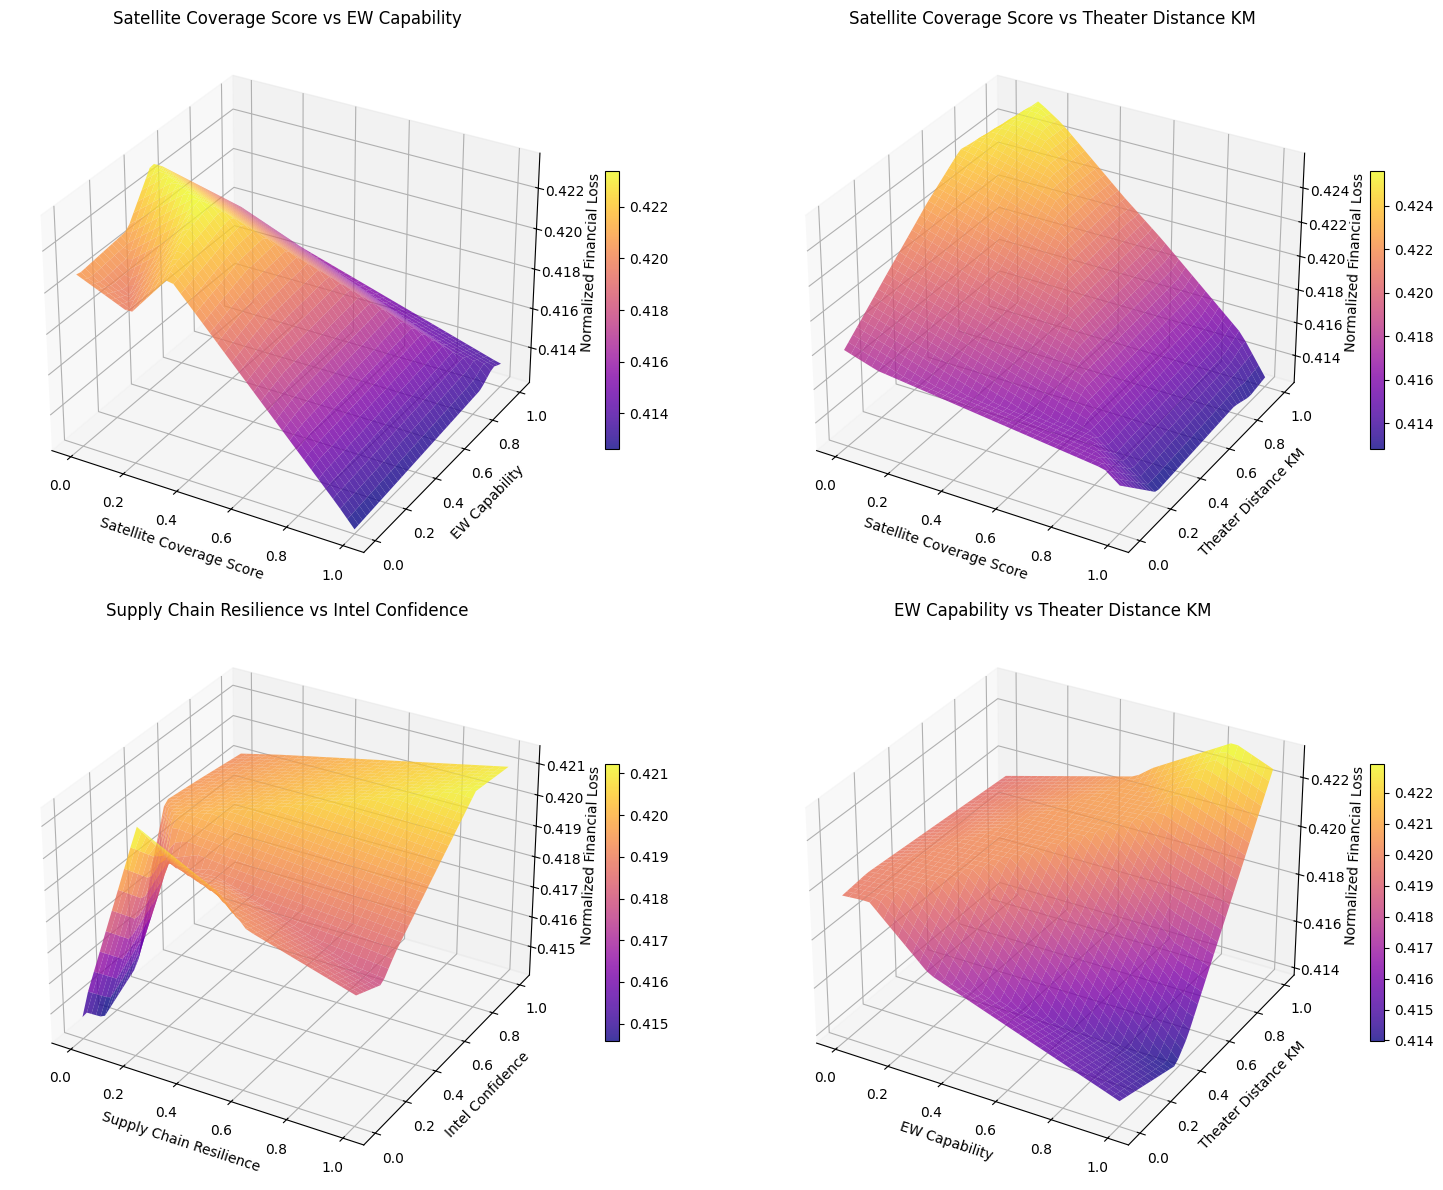

In [18]:
# from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))

input_names = [
    'Satellite Coverage Score',
    'EW Capability',
    'Supply Chain Resilience',
    'Intel Confidence',
    'Theater Distance KM'
]

# Create surface plots for key pairs
pairs = [(0, 1), (0, 4), (2, 3), (1, 4)]

for plot_idx, (i, j) in enumerate(pairs):
    ax = fig.add_subplot(2, 2, plot_idx + 1, projection='3d')
    
    # Create grid
    input_range = np.linspace(0, 1, 40)
    X, Y = np.meshgrid(input_range, input_range)
    Z = np.zeros_like(X)
    
    # Compute predictions for grid
    for x_idx in range(len(input_range)):
        for y_idx in range(len(input_range)):
            input_vector = np.mean(inputs, axis=1)
            input_vector[i] = X[y_idx, x_idx]
            input_vector[j] = Y[y_idx, x_idx]
            
            input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
            with torch.no_grad():
                pred = model(input_tensor).item()
            Z[y_idx, x_idx] = pred
    
    # Plot surface
    surf = ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.8)
    ax.set_xlabel(input_names[i], fontsize=10)
    ax.set_ylabel(input_names[j], fontsize=10)
    ax.set_zlabel('Normalized Financial Loss', fontsize=10)
    ax.set_title(f'{input_names[i]} vs {input_names[j]}')
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5)

plt.tight_layout()
plt.show()

In [35]:
# model prediction for input vector of all 0.5 values
input_vector = np.array([0.99, 0.99, 0.9, 0.9, 0.9])
input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
with torch.no_grad():
    pred = model(input_tensor).item()
print(f"Model prediction for input vector {input_vector}:", pred)

# compare model predictions for first 5 input vectors in dataset vs actual output values
input_vectors = np.transpose(inputs)
for vec in input_vectors[:5]:
    input_tensor = torch.tensor(vec).float().unsqueeze(0)
    with torch.no_grad():
        pred = model(input_tensor).item()
    print(f"Model prediction for input vector {vec}:", pred)
    print(f"Actual output value:", output[np.all(input_vectors == vec, axis=1)][0])

# calculate mean square error on test dataset 
print(test_dataset[0])
mse = 0
for input, output in test_dataset:
    input_tensor = input.unsqueeze(0)
    with torch.no_grad():
        pred = model(input_tensor).item()
    print(f"Model prediction: {pred}, Actual output: {output.item()}")
    mse += (pred - output.item())**2
mse /= len(test_dataset)
print(f"Mean Squared Error on test dataset: {mse}")
    


Model prediction for input vector [0.99 0.99 0.9  0.9  0.9 ]: 0.4110056459903717
Model prediction for input vector [0.4875     0.2        0.15       0.74285714 0.49092403]: 0.41962820291519165
Actual output value: 0.5462184873949579
Model prediction for input vector [0.4375     0.6        0.9        0.78571429 0.70003477]: 0.42222899198532104
Actual output value: 0.3042016806722689
Model prediction for input vector [0.85       0.1        0.38333333 0.72857143 0.65334331]: 0.41456854343414307
Actual output value: 0.36470588235294116
Model prediction for input vector [1.         0.1        0.8        0.67142857 0.14190748]: 0.41263389587402344
Actual output value: 0.44873949579831934
Model prediction for input vector [0.725      0.8        0.38333333 0.14285714 0.05044195]: 0.41858965158462524
Actual output value: 0.29747899159663865
(tensor([0.9125, 0.7000, 0.1000, 0.1000, 0.9242]), tensor(0.7076))
Model prediction: 0.4200228154659271, Actual output: 0.707563042640686
Model prediction: 

In [30]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate on entire dataset
model.eval()
all_predictions = []
all_true_values = []

with torch.no_grad():
    for data, labels in DataLoader(full_dataset, batch_size=32):
        outputs = model(data)
        all_predictions.extend(outputs.numpy().flatten())
        all_true_values.extend(labels.numpy().flatten())

all_predictions = np.array(all_predictions)
all_true_values = np.array(all_true_values)

# Calculate metrics
mae = mean_absolute_error(all_true_values, all_predictions)
r2 = r2_score(all_true_values, all_predictions)
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
mape = np.mean(np.abs((all_true_values - all_predictions) / all_true_values)) * 100

print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 0.117181
Root Mean Squared Error (RMSE): 0.145004
R² Score: 0.000903
Mean Absolute Percentage Error (MAPE): inf%


/var/folders/5f/wknmn3k14d5fz_8gz585pj_w0000gn/T/ipykernel_89624/3806395574.py:21: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((all_true_values - all_predictions) / all_true_values)) * 100


next steps: filter by threat types ?? 

separate models vs differential model 

send dod cyber stuff 
incomplete input - stakeholder ask, post mvp 

how easy is variable x to know at the time the model would be used? e.g. pre engagement 

hybrid 

try rf


